### Libraries

In [15]:
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torch

In [ ]:
!unzip experiment.zip -d .
%load_ext tensorboard
%tensorboard --logdir ./experiment/

In [16]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset & general parameters

In [18]:
def generate_clusters_data(dataset_size, dim, n_clusters=5):
    sigmas = []
    mus = []
    X = []

    for _ in range(n_clusters):
        center = np.random.uniform(-5, 5, dim) # center of gaussian
        scales = np.random.uniform(1, 2, dim) # covariance

        # Generate cloud of points
        cluster = np.random.multivariate_normal(mean=center, cov=np.diag(scales), size=dataset_size)

        sigmas.append(scales)
        mus.append(center)
        X.append(cluster)

    X = np.stack(X).reshape(-1, dim)

    return X, mus, sigmas

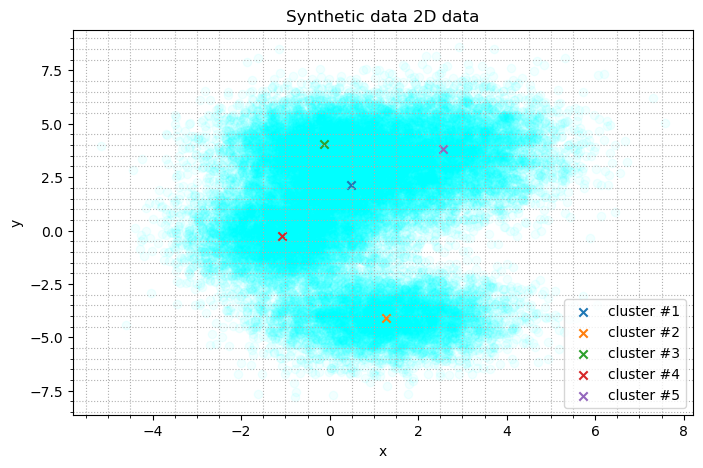

In [19]:
dataset_size = 5555
n_clusters = 5
dim = 2

X, mus, sigmas = generate_clusters_data(dataset_size, dim, n_clusters)
x, y = X.T

plt.figure(figsize=(8, 5))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.scatter(x, y, c='cyan', alpha=0.05)

for i, mu in enumerate(mus):
    plt.scatter(mu[0], mu[1], label=f"cluster #{i + 1}", marker='x')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Synthetic data 2D data')
plt.show()

### General training code

In [ ]:
def train_on_batch(model, x_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()

    output = model(x_batch.to(model.device))
    loss = model.loss(*output)
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [ ]:
def train_epoch(train_generator, model, loss_function, optimizer, scheduler=None, callback=None):
    epoch_loss = 0
    total = 0

    for it, batch_of_x in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x[0], optimizer, loss_function)

        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)

        epoch_loss += batch_loss * len(batch_of_x)
        total += len(batch_of_x)

    scheduler.step()

    return epoch_loss / total

In [ ]:
def trainer(count_of_epoch,
            batch_size,
            dataset,
            model,
            loss_function,
            optimizer,
            lr=0.001,
            callback=None):

    optima = optimizer(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optima, gamma=0.95)

    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})

    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True),
            leave=False, total=len(dataset) // batch_size + (len(dataset) % batch_size > 0))

        epoch_loss = train_epoch(train_generator=batch_generator,
                    model=model,
                    loss_function=loss_function,
                    optimizer=optima,
                    scheduler=scheduler,
                    callback=callback)

        iterations.set_postfix({'train epoch loss': epoch_loss})

### Variational autoencoder

In [ ]:
class VanillaVAE(torch.nn.Module):
    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 n_layers):
        super().__init__()

        self.latent_dim = latent_dim

        hidden_dims = [6 * (2 ** i) for i in range(n_layers)]

        self.fc_mu = torch.nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = torch.nn.Linear(hidden_dims[-1], latent_dim)

        self.encoder_input = torch.nn.Linear(input_dim, hidden_dims[0])
        self.decoder_input = torch.nn.Linear(latent_dim, hidden_dims[-1])

        encoder_modules = []
        decoder_modules = []

        for i in range(len(hidden_dims) - 1):
            encoder_modules.append(
                torch.nn.Sequential(
                    torch.nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                    torch.nn.BatchNorm1d(hidden_dims[i + 1]),
                    torch.nn.LeakyReLU())
            )

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            decoder_modules.append(
                torch.nn.Sequential(
                    torch.nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                    torch.nn.BatchNorm1d(hidden_dims[i + 1]),
                    torch.nn.LeakyReLU())
            )

        self.encoder = torch.nn.Sequential(self.encoder_input, *encoder_modules)
        self.decoder = torch.nn.Sequential(self.decoder_input, *decoder_modules)

        self.final_layer = torch.nn.Sequential(
                            torch.nn.Linear(hidden_dims[-1], hidden_dims[-1]),
                            torch.nn.BatchNorm1d(hidden_dims[-1]),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dims[-1], input_dim))

    def encode(self, input):
        """
        Generates distribution provided by input.
        Args:
            input: Tensor - the matrix of shape batch_size x input_dim.
        Returns:
            List[mu, log_var] - the normal distribution parameters.
            mu: Tensor - the matrix of shape batch_size x latent_dim.
            sigma: Tensor - the matrix of shape batch_size x latent_dim.
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes onto the image space.
        Args:
            z: Tensor - the matrix of shape batch_size x latent_dim.
        Returns:
            Tensor - decoded sample.
        """
        result = self.decoder(z)
        result = self.final_layer(result)

        return result

    def sample_z(self, mu, logvar):
        """
        Generates sample from normal distribution N(mu, var).
        Args:
            mu: Tensor - the matrix of shape batch_size x latent_dim.
            sigma: Tensor - the matrix of shape batch_size x latent_dim.
        Returns:
            Tensor - the tensor of shape batch_size x latent_dim - samples from normal distribution in latent space.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.sample_z(mu, log_var)

        return [self.decode(z), input, mu, log_var]

    def loss(self, *args, **kwargs):
        """
        Computes the VAE loss function.
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        recons_loss = torch.nn.functional.mse_loss(recons, input)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0) # KL-divergention

        loss = recons_loss + kld_loss
        return loss # {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def generate_samples(self, num_samples:int, **kwargs):
        """
        Samples from the latent space and return the corresponding image space map.
        Args:
            num_samples: int - the number of samples, witch need to generate.
        Returns:
            Tensor - the matrix of shape num_samples x input_dim.
        """
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(self.device)

        samples = self.decode(z)
        return samples

    def generate(self, x, **kwargs):
        """
        Generate decoded sample after encoding.
        Args:
            x: Tensor - the matrix of shape batch_size x input_dim.
        Returns:
            Tensor - decoded sample after encoding of x.
        """
        return self.forward(x)[0]

### Tensorboard training tracking

In [ ]:
class callback():
    def __init__(self, writer, dataset_loader, loss_function, delimeter=100):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function

        self.dataset_loader = dataset_loader

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)

    def __call__(self, model, loss):
        return self.forward(model, loss)

### Variational autoencoder training

In [ ]:
optimizer = torch.optim.Adam

In [ ]:
grid = ParameterGrid({
    'latent_dim': [2, 4, 8, 16, 32],
    'n_layers': [4, 8, 12],
})

grid_input_dim = ParameterGrid({
    'input_dim': [2, 8, 14],
})

for input_dim_item in grid_input_dim:
    X, mus, sigmas = generate_clusters_data(dataset_size=20000, dim=input_dim_item['input_dim'])

    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X[:15000, :], dtype='float32')))
    test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X[15000:, :], dtype='float32')))

    for item in grid:
        print(str(input_dim_item), str(item))

        vae = VanillaVAE(
            latent_dim=item['latent_dim'],
            input_dim=input_dim_item['input_dim'],
            n_layers=item['n_layers'])

        vae.to(device)
        vae.device=device

        writer = SummaryWriter(log_dir=('experiment/' + str(str(input_dim_item)) + str(item)))
        call = callback(writer, test_dataset, vae.loss, delimeter=100)

        trainer(count_of_epoch=7,
                batch_size=100,
                dataset=train_dataset,
                model=vae,
                loss_function=vae.loss,
                optimizer=optimizer,
                lr=0.001,
                callback=call)

        if input_dim_item['input_dim'] == 2:
            print("Picture")
            distr = vae.generate_samples(1000)
            x, y = np.array(distr.detach().cpu()).T

            plt.figure(figsize=(5, 4), dpi=100)
            decoding = vae.generate(distr).detach().cpu()

            plt.scatter(x, y, label='Initial data')
            plt.scatter(decoding[:, 0], decoding[:, 1], label='Generated data')
            plt.axis('equal')
            plt.legend()
            writer.add_figure('Samples', plt.gcf())
            plt.show()